# Doubt Activity Analysis

<font size="3"> **Done by** - Aayush Bajaj

In [1]:
# Importing Dependencies

from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

<img src="img/DRM_StateDiagram.png" width="1500" height="600">

In [2]:
'''
Importing Tables and checking memory used
'''

activities = pd.read_csv('data/activities.csv', parse_dates = ['created_at'])
doubts = pd.read_csv('data/doubts.csv', parse_dates = ['created_at'])

display(activities)
print('Activities Set Memory Usage = {:.2f} MB'.format(activities.memory_usage().sum() / 1024**2))
print('----------------------------------------')
display(doubts)
print('doubts Set Memory Usage = {:.2f} MB'.format(doubts.memory_usage().sum() / 1024**2))

,id,user_id,doubt_id,created_at,activity_type
0,2121357,120623,248193,2020-01-01 04:26:08+00:00,assign
1,2121358,120623,248193,2020-01-01 04:26:15+00:00,accept
2,2121359,165368,248199,2020-01-01 04:29:18+00:00,assign
3,2121360,165368,248199,2020-01-01 04:29:34+00:00,reject
4,2121399,265305,248191,2020-01-01 04:35:07+00:00,assign
...,...,...,...,...,...
76203,4322614,229989,252698,2020-05-01 12:26:00+00:00,rate
76204,4322618,229989,249512,2020-05-01 12:26:07+00:00,rate
76205,4699532,47336,249949,2020-05-12 13:53:29+00:00,rate
76206,4905034,175678,252370,2020-05-18 13:24:14+00:00,rate


Activities Set Memory Usage = 2.91 MB
----------------------------------------


,id,user_id,course_id,created_at,content_type,user_rating,state
0,248188,280541,10,2020-01-01 00:58:22+00:00,Code Problem,5.0,resolved
1,248189,32227,12,2020-01-01 02:02:21+00:00,Multiple Problem,5.0,resolved
2,248190,357687,1,2020-01-01 02:14:37+00:00,Single_choice Problem,5.0,resolved
3,248191,486150,11,2020-01-01 02:15:15+00:00,No_submission Problem,4.0,resolved
4,248192,367920,13,2020-01-01 03:16:19+00:00,Datascience Problem,5.0,resolved
...,...,...,...,...,...,...,...
4995,253194,332893,1,2020-01-08 14:33:21+00:00,VideoOffering,4.0,resolved
4996,253195,388697,2,2020-01-08 14:33:27+00:00,Code Problem,5.0,resolved
4997,253196,282065,1,2020-01-08 14:34:12+00:00,Code Problem,5.0,resolved
4998,253197,32802,12,2020-01-08 14:34:22+00:00,Frontend Problem,5.0,resolved


doubts Set Memory Usage = 0.27 MB


In [75]:
def draw_missing_data_table(df):
    '''
    Docstring: Returns a datarframe with percent of missing/nan values per feature/column
    
    Parameters:
    ------------
    df: dataframe object
    
    Returns:
    ------------
    Dataframe containing missing value information
    '''
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [4]:
draw_missing_data_table(activities)

,Total,Percent
activity_type,0,0.0
created_at,0,0.0
doubt_id,0,0.0
user_id,0,0.0
id,0,0.0


In [5]:
draw_missing_data_table(doubts)

,Total,Percent
user_rating,12,0.0024
state,0,0.0000
content_type,0,0.0000
created_at,0,0.0000
course_id,0,0.0000
user_id,0,0.0000
id,0,0.0000


<font size='3'> There are 12 missing values in doubts table for `user_rating` which is plausible for number of reasons
- <font size='3'>User didn't gave a review (major one)
- <font size='3'>It wasn't recorded
    
<font size='3'>So to fill in for it I'll just replace the NaN's with `No Rating` string.

In [3]:
doubts.user_rating.fillna('NR',inplace=True)

# First Impressions of the Dataset
- <font size='3'>**id** in activities table should be `activity_id`
- <font size='3'>Since **user_id** in **activity table** contains three different information as metadata. To counter that we'll introduce three ```One-Hot-Features``` to the activities table which will signify if the user_id is student_id or TA_id or system_id.
- <font size='3'>`created_at` is formated by "date HH:MM:SS" and Time is in `UTC`
- <font size='3'>**id** in **doubts table** is `doubt_id` (to be used as a foriegn key, used in joining tables)
- <font size='3'>**user_id** in **doubts table** is just student_id (same in user_id in activities since the activity_type is resolved in doubts table)

<font size="3">To make ```One-Hot-Features``` following logic is applied.
```python
if activity_type ∈ (resolve, rate, review_not_resolved, not_pending_action_done, not_pending_info_submit):
    user_id = student_id
    
elif activity_type ∈ (activate, reject, pending_action_required, pending_information_required, review_resolution,assign, accept,reactivate, escalate):
    user_id = TA_id
    
elif activity_type ∈ (unassign, inactivate, pending_sms, pending_reminder_first, pending_reminder_second, dead):
    user_id = system_id
```

In [38]:
# getting the unique activity_types for reference
activities.activity_type.unique()

array(['assign', 'accept', 'reject', 'review_resolution', 'reactivate',
       'resolve', 'rate', 'pending_action_required', 'inactivate',
       'unassign', 'escalate', 'review_not_resolved',
       'not_pending_action_done', 'pending_information_required',
       'not_pending_info_submit', 'activate', 'pending_reminder_first',
       'pending_reminder_second'], dtype=object)

In [4]:
def is_student(x):
    if (x['activity_type'] in ['rate', 'review_not_resolved', 'not_pending_action_done', 'not_pending_info_submit','resolve']):
        return '1'
    else:
        return '0'

activities['is_student_id'] = activities.apply(lambda x:is_student(x),axis=1)
activities.is_student_id = activities.is_student_id.astype(int)

In [5]:
def is_TA(x):
    if (x['activity_type'] in ['activate','reject','pending_action_required','pending_information_required',
                               'review_resolution','assign','accept','reactivate','escalate']):
        return '1'
    else:
        return '0'

activities['is_TA_id'] = activities.apply(lambda x:is_TA(x),axis=1)
activities.is_TA_id = activities.is_TA_id.astype(int)

In [6]:
def is_sys(x):
    if (x['activity_type'] in ['unassign', 'inactivate', 'pending_sms', 'pending_reminder_first', 'pending_reminder_second', 'dead']):
        return '1'
    else:
        return '0'

activities['is_sys_id'] = activities.apply(lambda x:is_sys(x),axis=1)
activities.is_sys_id = activities.is_sys_id.astype(int)

In [12]:
activities

,id,user_id,doubt_id,created_at,activity_type,is_student_id,is_TA_id,is_sys_id
0,2121357,120623,248193,2020-01-01 04:26:08+00:00,assign,0,1,0
1,2121358,120623,248193,2020-01-01 04:26:15+00:00,accept,0,1,0
2,2121359,165368,248199,2020-01-01 04:29:18+00:00,assign,0,1,0
3,2121360,165368,248199,2020-01-01 04:29:34+00:00,reject,0,1,0
4,2121399,265305,248191,2020-01-01 04:35:07+00:00,assign,0,1,0
...,...,...,...,...,...,...,...,...
76203,4322614,229989,252698,2020-05-01 12:26:00+00:00,rate,1,0,0
76204,4322618,229989,249512,2020-05-01 12:26:07+00:00,rate,1,0,0
76205,4699532,47336,249949,2020-05-12 13:53:29+00:00,rate,1,0,0
76206,4905034,175678,252370,2020-05-18 13:24:14+00:00,rate,1,0,0


---

## Resolution Time

### Resolution time for every doubt resolved in doubts table

In [88]:
# id in doubts table (doubt_id) is unique (primary key)
doubts

,id,user_id,course_id,created_at,content_type,user_rating,state
0,248188,280541,10,2020-01-01 00:58:22+00:00,Code Problem,5,resolved
1,248189,32227,12,2020-01-01 02:02:21+00:00,Multiple Problem,5,resolved
2,248190,357687,1,2020-01-01 02:14:37+00:00,Single_choice Problem,5,resolved
3,248191,486150,11,2020-01-01 02:15:15+00:00,No_submission Problem,4,resolved
4,248192,367920,13,2020-01-01 03:16:19+00:00,Datascience Problem,5,resolved
...,...,...,...,...,...,...,...
4995,253194,332893,1,2020-01-08 14:33:21+00:00,VideoOffering,4,resolved
4996,253195,388697,2,2020-01-08 14:33:27+00:00,Code Problem,5,resolved
4997,253196,282065,1,2020-01-08 14:34:12+00:00,Code Problem,5,resolved
4998,253197,32802,12,2020-01-08 14:34:22+00:00,Frontend Problem,5,resolved


In [59]:
activities.loc[activities.activity_type=='available']

,id,user_id,doubt_id,created_at,activity_type,is_student_id,is_TA_id,is_sys_id


<font size="3"> Now according to the document the start state of the doubt resolution process is ```available``` but no such state exists in activities table.<br>
<font size="3"> To tackle this I'm assuming the ***assign*** state the starting point of Doubt resolution process (first state)

In [7]:
'''
Standardizing Time to minutes
'''

def convert_timedelta(duration):
    days, seconds = duration.days, duration.seconds

    minutes = (seconds % 3600) / 60
    return minutes

In [76]:
activities.loc[activities.doubt_id==248205]

,id,user_id,doubt_id,created_at,activity_type,is_student_id,is_TA_id,is_sys_id
82,2121762,175223,248205,2020-01-01 06:46:24+00:00,assign,0,1,0
83,2121763,175223,248205,2020-01-01 06:46:34+00:00,accept,0,1,0
89,2121772,175223,248205,2020-01-01 06:49:38+00:00,review_resolution,0,1,0
93,2121777,417024,248205,2020-01-01 06:50:07+00:00,review_not_resolved,1,0,0
95,2121779,175223,248205,2020-01-01 06:50:11+00:00,assign,0,1,0
...,...,...,...,...,...,...,...,...
363,2122266,175223,248205,2020-01-01 09:19:49+00:00,pending_action_required,0,1,0
24310,2152208,71,248205,2020-01-04 10:00:43+00:00,pending_reminder_first,0,0,1
50302,2179121,71,248205,2020-01-07 11:00:42+00:00,pending_reminder_second,0,0,1
59960,2188894,417024,248205,2020-01-08 11:00:43+00:00,resolve,1,0,0


<font size="3"> Another major thing to note here is for a particluar doubt **id** in doubts table there are multiple assign states. Which is considerable since a partcular doubt can be raised again for multiple reasons:
- <font size="3">TA needed some more information or Information wasn't sufficient
- <font size="3">User wasn't satisfied so the doubt was made ```available``` after ```resolved_review_pending```.
- <font size="3">Some technical issues
    
<font size="3"> To tackle this while calculating the DRT I've made few **Assumptions**:
- <font size="3">For a user perspective the total time will be first time he raised a doubt to the point of resolution, but for an intermediate TA the time is different. So I introduce two features (which will be calculated):<br>
    
    <font size="3">**DRT** = Doubt Resolution Time, which wil signify time taken by the last TA to solve the problem (which he'll be credited for)<br>
    <font size="3">**Doubt_life_cycle** = Total time, doubt with a particular `doubt_id` remained in the system<br>

- <font size="3">Multiple TA's are assigned to and worked on one doubts which is plausible since a doubt can be made available again if the user isnt satisfied or the doubt needed some new information to be solved.
To work this I'm assuming the doubt assigned to last TA (according to assigned Timestamp) has solved it and it should be him who should get the credit for solving.

In [8]:
# pick one id from doubts table (doubt_id) and extract corresponding created in activities table

dlc = []
drt = []
TA_id = []
with tqdm(total=len(doubts)) as pbar:
    for index, row in doubts.iterrows():
        doubt_id = row['id']
        
        # finding when was the doubt attained its first "assign" state by sorting through all assign states and picking the earliest
        try:
            # Doubt_life_cycle
            assign_time = activities.loc[(activities.doubt_id==doubt_id) & 
                                         (activities.activity_type=='assign'),
                                         ('created_at')].sort_values().iloc[0]

            resolution_time = row['created_at']

            dlc.append(convert_timedelta(resolution_time-assign_time))
            
        except Exception as e:
            #print("Exception Occurred:",e)
            dlc.append(1)
            
        try:
            # DRT
            t = activities.loc[(activities.doubt_id==doubt_id) & 
                                (activities.activity_type=='assign') &
                                (activities.is_TA_id==1),
                                ('created_at','user_id')].sort_values(by='created_at').iloc[-1]
            
            assign_time = t['created_at']
            resolution_time = row['created_at']
            
            TA_id.append(t['user_id'])
            drt.append(convert_timedelta(resolution_time-assign_time))
            
        except Exception as e:
            #print("Exception Occurred:",e)
            drt.append(1)
            TA_id.append('not_assigned/resolve')
            
        pbar.update(1)
        

100%|██████████| 5000/5000 [01:19<00:00, 63.16it/s]


In [9]:
doubts['Doubt_resolution_time(min)'] = drt
doubts['Doubt_life_cycle(min)'] = dlc
doubts['TA_id'] = TA_id

In [10]:
doubts

,id,user_id,course_id,created_at,content_type,user_rating,state,Doubt_resolution_time(min),Doubt_life_cycle(min),TA_id
0,248188,280541,10,2020-01-01 00:58:22+00:00,Code Problem,5,resolved,41.050000,44.850000,34120
1,248189,32227,12,2020-01-01 02:02:21+00:00,Multiple Problem,5,resolved,23.216667,23.216667,156881
2,248190,357687,1,2020-01-01 02:14:37+00:00,Single_choice Problem,5,resolved,29.316667,29.316667,165368
3,248191,486150,11,2020-01-01 02:15:15+00:00,No_submission Problem,4,resolved,40.716667,40.133333,208720
4,248192,367920,13,2020-01-01 03:16:19+00:00,Datascience Problem,5,resolved,5.633333,33.233333,163412
...,...,...,...,...,...,...,...,...,...,...
4995,253194,332893,1,2020-01-08 14:33:21+00:00,VideoOffering,4,resolved,20.950000,52.333333,126618
4996,253195,388697,2,2020-01-08 14:33:27+00:00,Code Problem,5,resolved,57.566667,0.000000,112367
4997,253196,282065,1,2020-01-08 14:34:12+00:00,Code Problem,5,resolved,23.133333,42.633333,331381
4998,253197,32802,12,2020-01-08 14:34:22+00:00,Frontend Problem,5,resolved,57.350000,57.450000,38663


---

# Doubt Resolution Time for every TA (TA analysis)

<font size="3"> In this section we'll see:
- <font size="3">`Distribution of DRT` in multiple aspects
- <font size="3">Identifying the `Top performers` on the basis of time they took to solve doubts they were assigned.

q1= 31.769523809523818
q3= 40.21441441441441
IQR: 8.444890604890588


Text(0.5, 1.0, 'Sampling Distribution of mean Doubt Resolution by each TA')

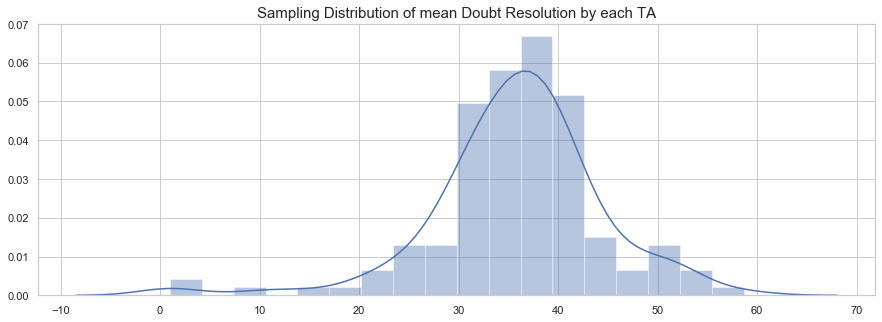

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))

x =doubts.groupby('TA_id', as_index=False)['Doubt_resolution_time(min)'].mean().sort_values(by='Doubt_resolution_time(min)')

print('q1=',np.percentile(x['Doubt_resolution_time(min)'], 25))
print('q3=',np.percentile(x['Doubt_resolution_time(min)'], 75))
print("IQR:",np.subtract(*np.percentile(x['Doubt_resolution_time(min)'].values, [75, 25])))

sns.distplot(x['Doubt_resolution_time(min)'].values,ax=ax);
ax.set_title('Sampling Distribution of mean Doubt Resolution by each TA', fontsize=15)

<font size="3"> In the distribution plot above we can see that higher proportion of the TA's solves the **average doubt assigned to them in [31-40] minutes range**. This Sampling Distribution is close to a Normal Distribution with some degree of `left skewness`.

### Performance of a TA will also depend on the number of problems solved by them. So looking at that distribution will also be necesaary

In [21]:
df = doubts.groupby('TA_id', as_index=False)['Doubt_resolution_time(min)'].mean()
df.to_csv('DRT_perTA.csv',index=False)

Total Number of Problems solved by TAs  : 4765
Average Number of Problems solved by TAs: 33


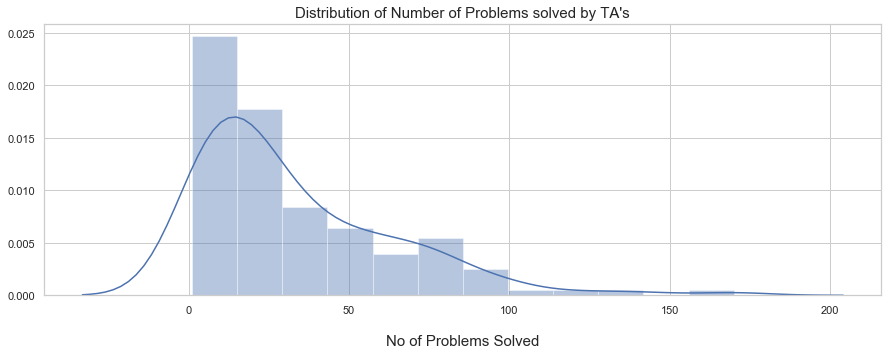

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

TOTAL_NO_OF_PROBLEMS_SOLVED_BY_EACH_TA = doubts.loc[doubts.TA_id!='not_assigned/resolve'].TA_id.value_counts()

print("Total Number of Problems solved by TAs  :",TOTAL_NO_OF_PROBLEMS_SOLVED_BY_EACH_TA.sum())
print("Average Number of Problems solved by TAs:",int(TOTAL_NO_OF_PROBLEMS_SOLVED_BY_EACH_TA.mean()))
sns.distplot(TOTAL_NO_OF_PROBLEMS_SOLVED_BY_EACH_TA.values,ax=ax);
ax.set_title("Distribution of Number of Problems solved by TA's", fontsize=15)
ax.set_xlabel('No of Problems Solved', size=15, labelpad=20)

TOTAL_NO_OF_PROBLEMS_SOLVED_BY_EACH_TA.to_csv("TOTAL_NO_OF_PROBLEMS_SOLVED_BY_EACH_TA.csv",index=False)

- <font size="3">You can see in the distribution plot above that very less number of TAs (highly competent or experienced ones') solves more than 100 problems.
- <font size="3">Most concentration of the no of problems solved by TA's is around 0-50 if we're being flexible

#### **Thoughts after Distribution check:**
- <font size="3">Both distribution seems totally different. DRT Distribution sees a almost Normal Distribution which is a good sign but on the other hand No of problems distribution is highly skewed to the right which is a bad sign.
- <font size="3">This means TA's are solving problems at reasonable times but the frequency is very less to make it to adequate level of solving.

## Identifying Top performers

<font size="3">We define Rank Metric for TA's as
```python
Rank_Metric = No_of_Problems_solved*User_rating/ Average_Doubt_Resolution_Time
```

#### **The above metric constitutes all the cases to judge a TA on its merit:**
- <font size="3">A TA should be solving problems more frequently
- <font size="3">He should be recieving a good rating from the users
- <font size="3">Solving doubts at reasonable time at best

#### **But it has it some ambiguties like:**
- <font size="3">A low user rating may not be a TA's fault (other paramters like Doubt Life Cycle and technical issue)

In [51]:
t = doubts.loc[doubts.user_rating!='NR']  #NR won't be considered for the metric
t.user_rating = t.user_rating.astype(float)

In [41]:
RM = t.groupby('TA_id').agg({'TA_id':'count', 
                            'Doubt_resolution_time(min)':'mean',
                            'user_rating':'mean'
                             })
RM.columns = ['No_of_doubts_cleared','DRT','Mean_user_rating']
RM.drop(['not_assigned/resolve'],inplace=True)

In [45]:
RM['Rank_Metric'] = RM.No_of_doubts_cleared*RM.Mean_user_rating/RM.DRT
display(RM)

,No_of_doubts_cleared,DRT,Mean_user_rating,Rank_Metric
TA_id,,,,
1940,26,34.631410,3.884615,2.916428
6974,1,41.716667,4.000000,0.095885
8709,26,41.186538,4.500000,2.840734
10064,16,40.598958,4.562500,1.798076
11519,8,40.143750,4.375000,0.871867
...,...,...,...,...
296700,124,34.832930,4.467742,15.904490
309608,3,34.544444,5.000000,0.434223
331381,32,30.975521,4.562500,4.713399


,No_of_doubts_cleared,DRT,Mean_user_rating,Rank_Metric
TA_id,,,,
13443,170,41.198824,4.605882,19.005397
44538,141,37.118440,4.638298,17.619275
296700,124,34.832930,4.467742,15.904490
43738,96,34.057465,4.708333,13.271686
50408,96,34.479688,4.552083,12.674129
44368,96,36.593576,4.552083,11.941987
129364,107,41.983333,4.644860,11.838031
200604,91,38.029487,4.692308,11.228129
19839,73,32.497489,4.753425,10.677748


Text(0.5, 1.0, 'Top 10 Performers')

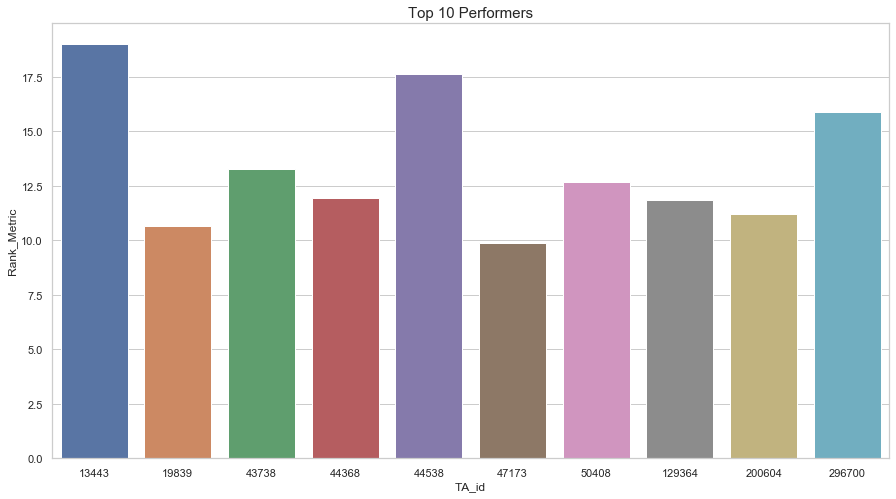

In [49]:
top_performers = RM.sort_values(by='Rank_Metric',ascending=False).iloc[:10]

display(top_performers)

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=top_performers.index,y='Rank_Metric', data=top_performers,ax=ax,capsize=.2)
ax.set_title('Top 10 Performers', fontsize=15)

#### From the bar plot above we know who our top performers are (don't forget to give them a raise xD)

---

# Doubt analysis on content type and course id

<font size="3"> Effect of Doubt life cycle time on different content types and Courses.

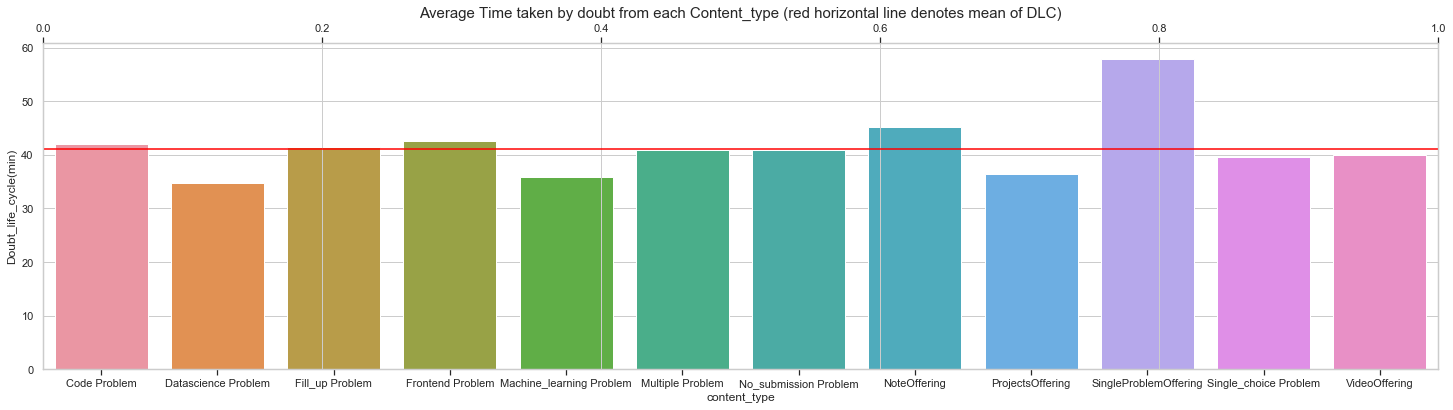

In [80]:
fig, ax1 = plt.subplots(figsize=(25, 6))
sns.barplot(x="content_type",
            y='Doubt_life_cycle(min)', 
            data= doubts.groupby('content_type', as_index=False)['Doubt_life_cycle(min)'].mean(),
            ax=ax1,
            capsize=.2)
ax1.set_title('Average Time taken by doubt from each Content_type (red horizontal line denotes mean of DLC)', fontsize=15)

ax2 = ax1.twiny()
ax2 = plt.axhline(y=doubts['Doubt_life_cycle(min)'].mean(),color='red')
plt.show()

#### In the plot above we can observe that
- <font size="3">Code Problem, Frontend problem, Note Offering, Single Problem Offering are the content_types (no particular course) in which the doubts took longer than average case.
- <font size="3">Single Problem Offering tops the list almost 55min average problem solving time

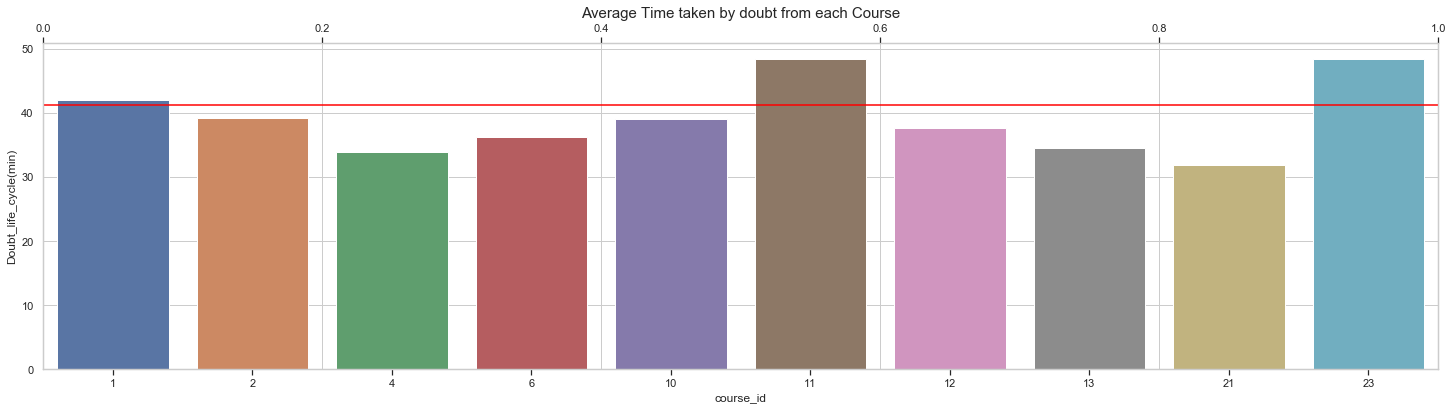

In [82]:
fig, ax1 = plt.subplots(figsize=(25, 6))

sns.barplot(x="course_id",
            y='Doubt_life_cycle(min)', 
            data= doubts.groupby('course_id', as_index=False)['Doubt_life_cycle(min)'].mean(),
            ax=ax1,
            capsize=.2)
ax1.set_title('Average Time taken by doubt from each Course', fontsize=15)

ax2 = ax1.twiny()
ax2 = plt.axhline(y=doubts['Doubt_life_cycle(min)'].mean(),color='red')

<font size="3">This denotes a similar plot now with different ```Course Ids```

Text(0, 0.5, 'Number of Requests')

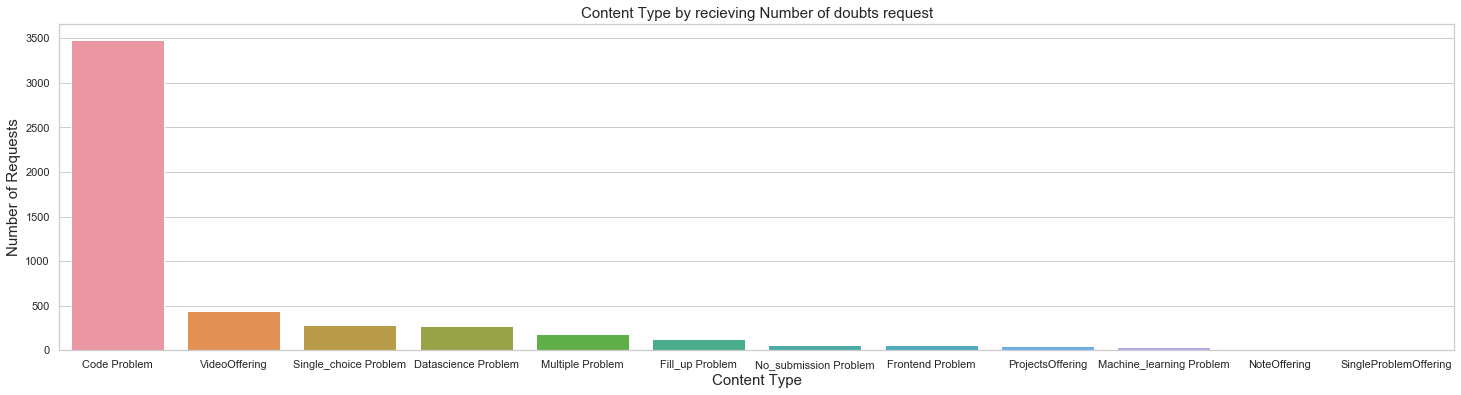

In [167]:
# which content_type recieved the most doubt requests (and were completed)
fig, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x=doubts.content_type.value_counts().index,y=doubts.content_type.value_counts(),ax=ax,capsize=.2)
ax.set_title('Content Type by recieving Number of doubts request', fontsize=15)
ax.set_xlabel('Content Type',fontsize=15)
ax.set_ylabel('Number of Requests',fontsize=15)

#### Observation from above plot:
- <font size="3">Code Problem has exceedingly large doubt request as compared to the other type of content type
- <font size="3">This leads to knowing that most of course contents involve a lot of Coding and Logic so this outcome is not surprising

## Combining Course Ids and Content Types

In [11]:
pd.set_option('display.max_rows', 68)
display(doubts.pivot_table(index=['course_id','content_type'],
                           values=['Doubt_life_cycle(min)','id'],
                           aggfunc={'Doubt_life_cycle(min)':'mean', 'id':'size'}))
pd.set_option('display.max_rows', 10)

Doubt_life_cycle(min)    id
course_id content_type                                         
1         Code Problem                          42.118379  1363
          Datascience Problem                   56.233333     1
          Fill_up Problem                       44.772727    55
          Multiple Problem                      43.466667    63
          No_submission Problem                 41.136364    22
          NoteOffering                          46.672222     3
          SingleProblemOffering                 57.541667     2
          Single_choice Problem                 44.611974   103
          VideoOffering                         36.330236   113
2         Code Problem                          40.179062   519
          Fill_up Problem                       28.001852     9
          Multiple Problem                      37.218519     9
          No_submission Problem                 29.505556     6
          NoteOffering                          33.366667     4
          Single_choice Problem                 28.371970    22
          VideoOffering                         38.373016    42
4         Code Problem                          32.786920    79
          Multiple Problem                      36.829762    14
          Single_choice Problem                 33.790000     5
          VideoOffering                         40.654762     7
6         Code Problem                          30.690351    19
          Fill_up Problem                       42.406250     8
          Machine_learning Problem              37.384444    15
          Multiple Problem                      47.362500     4
          NoteOffering                          39.666667     3
          ProjectsOffering                      31.633333     9
          Single_choice Problem                 32.440909    11
          VideoOffering                         39.531579    19
10        Code Problem                          39.006146   762
          Fill_up Problem                       40.516667    17
          Multiple Problem                      41.640556    30
          NoteOffering                           6.816667     1
          SingleProblemOffering                 58.166667     4
          Single_choice Problem                 38.472222    18
          VideoOffering                         36.993725    85
11        Code Problem                          48.338797   604
          Fill_up Problem                       59.316667     1
          Multiple Problem                      36.620370     9
          No_submission Problem                 49.492593    18
          NoteOffering                          57.055556     6
          Single_choice Problem                 46.889247    31
          VideoOffering                         50.363043    69
12        Fill_up Problem                       40.161111     3
          Frontend Problem                      40.350407    41
          Multiple Problem                      36.523656    31
          No_submission Problem                 47.133333     1
          NoteOffering                          58.775000     2
          ProjectsOffering                      27.466667     8
          Single_choice Problem                 36.341667    38
          VideoOffering                         37.451258    53
13        Code Problem                          29.185870    46
          Datascience Problem                   34.639795   276
          Fill_up Problem                       35.711333    25
          Machine_learning Problem              34.458333    18
          Multiple Problem                      33.660417     8
          No_submission Problem                 12.546667     5
          ProjectsOffering                      40.597531    27
          Single_choice Problem                 30.485185     9
          VideoOffering                         41.725758    22
21        Single_choice Problem                 31.550641    26
          VideoOffering                         32.883333     7
23  

In [12]:
pt = pd.DataFrame(doubts.groupby(['course_id','content_type'], as_index=False)\
                 .agg({'Doubt_life_cycle(min)':'mean', 'id':'size'}) \
                 .rename(columns={'Doubt_life_cycle(min)':'DLC','id':'Doubts_solved'}))

In [13]:
pt

,course_id,content_type,DLC,Doubts_solved
0,1,Code Problem,42.118379,1363
1,1,Datascience Problem,56.233333,1
2,1,Fill_up Problem,44.772727,55
3,1,Multiple Problem,43.466667,63
4,1,No_submission Problem,41.136364,22
...,...,...,...,...
63,23,Frontend Problem,49.421429,14
64,23,Multiple Problem,53.678333,10
65,23,No_submission Problem,47.012500,8
66,23,Single_choice Problem,41.046970,22


In [15]:
content_types = pt.content_type.unique()

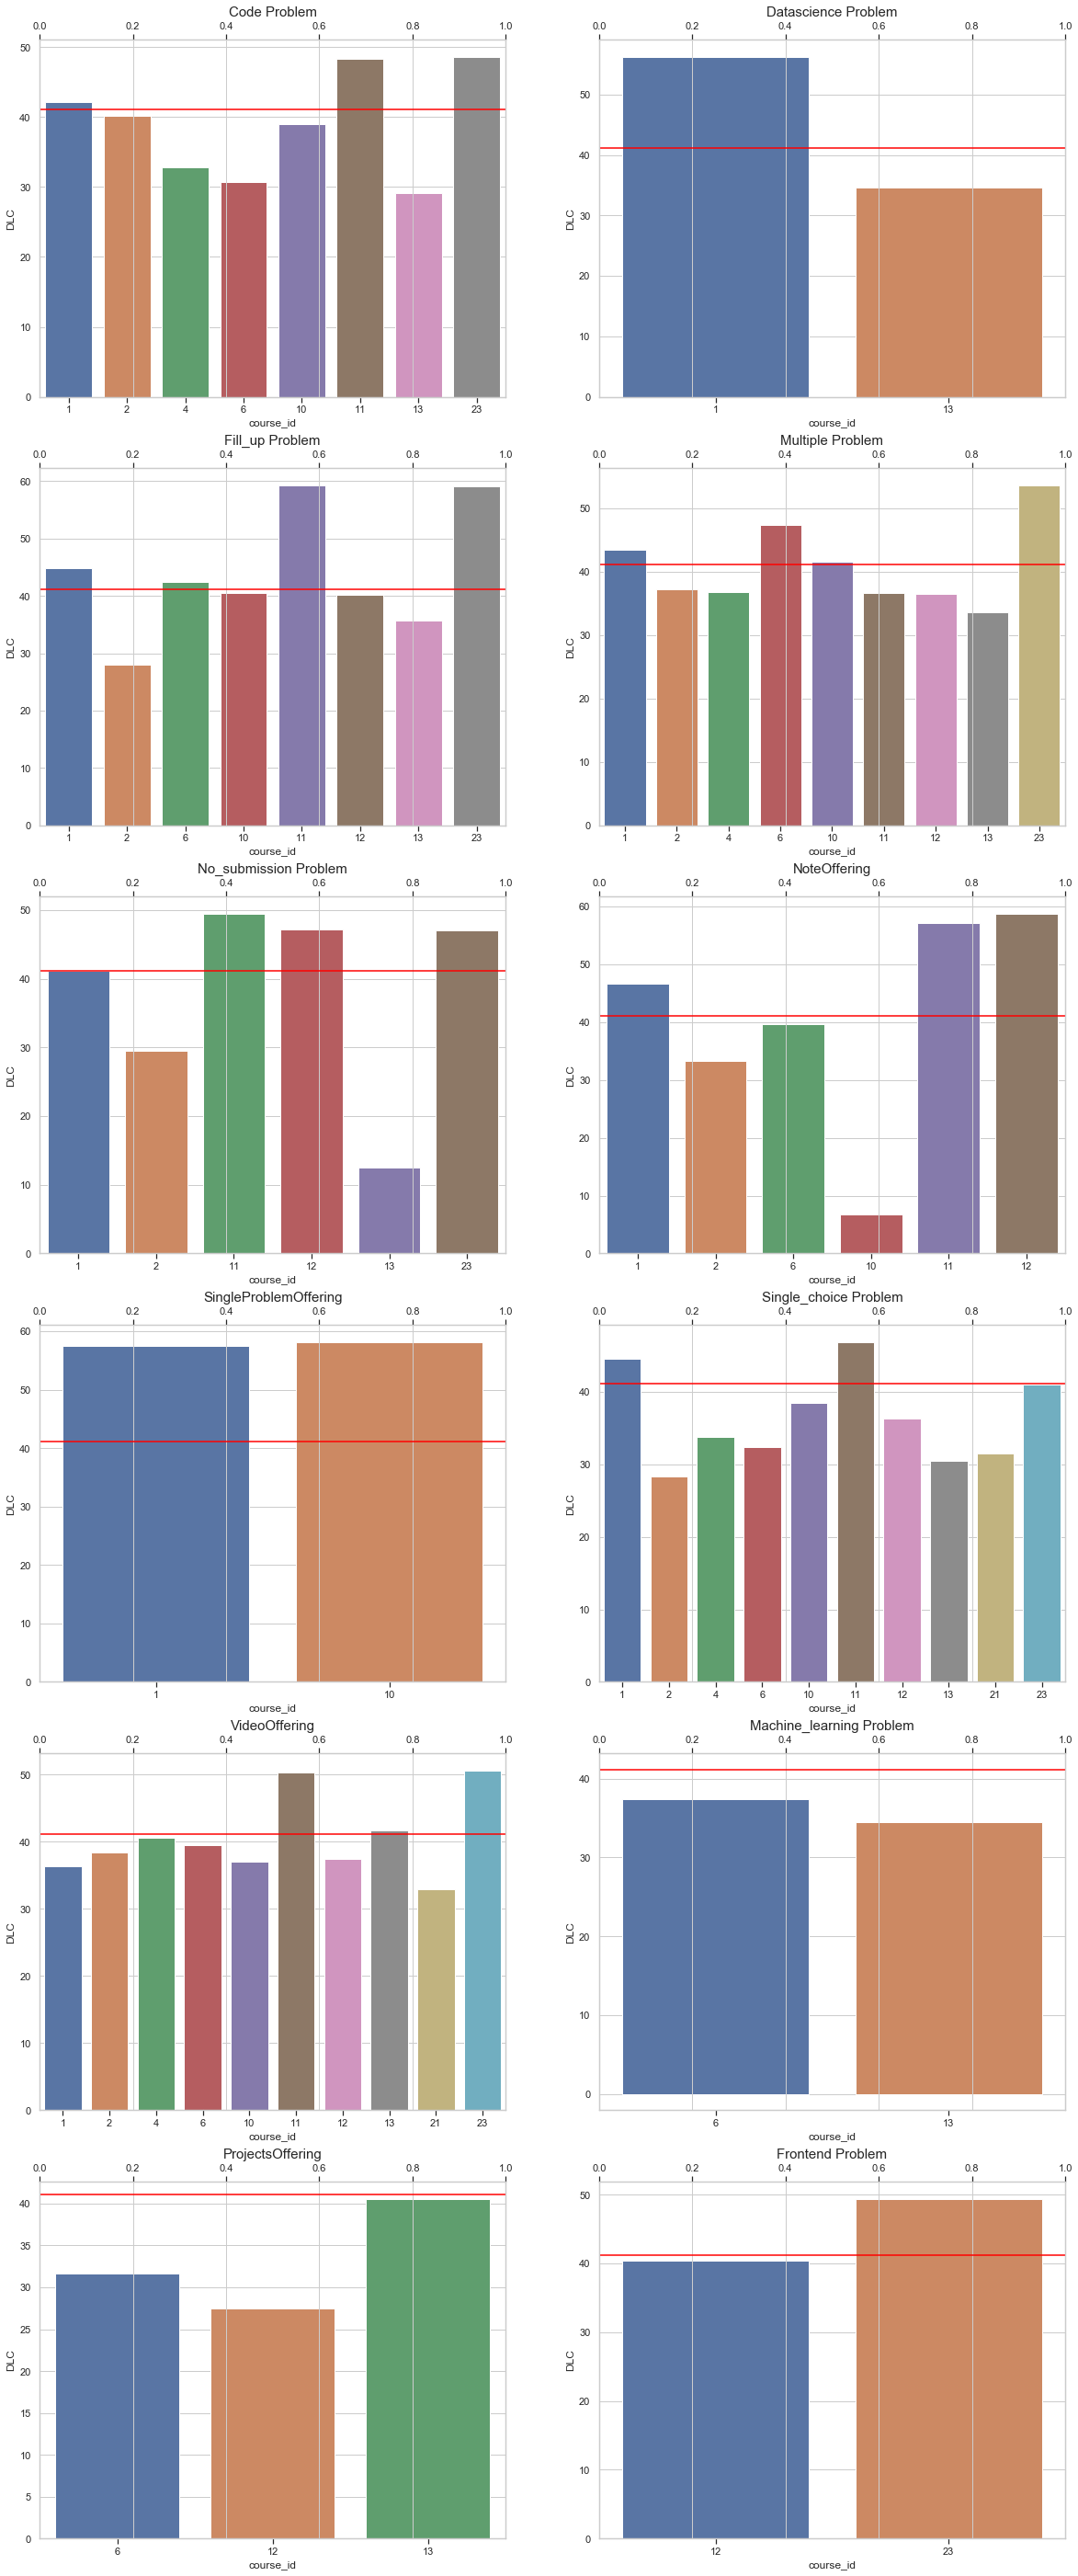

In [99]:
fig, ax = plt.subplots(nrows=int(len(content_types)/2),ncols=2,figsize=(20, 50))
ax=ax.flatten()
dlc_avg = doubts['Doubt_life_cycle(min)'].mean()
for i,ctype in enumerate(content_types):
    t = pt.loc[pt.content_type==ctype]

    g = sns.barplot(x='course_id',y='DLC', data=t, ax=ax[i], capsize=.2)
    
    #for index, row in t.iterrows():
    #    g.text(row.course_id, row.DLC, row.Doubts_solved, color='black', ha="center")
    
    ax[i].set_title(ctype, fontsize=15)
    
    ax2 = ax[i].twiny()
    ax2 = plt.axhline(y=dlc_avg,color='red')

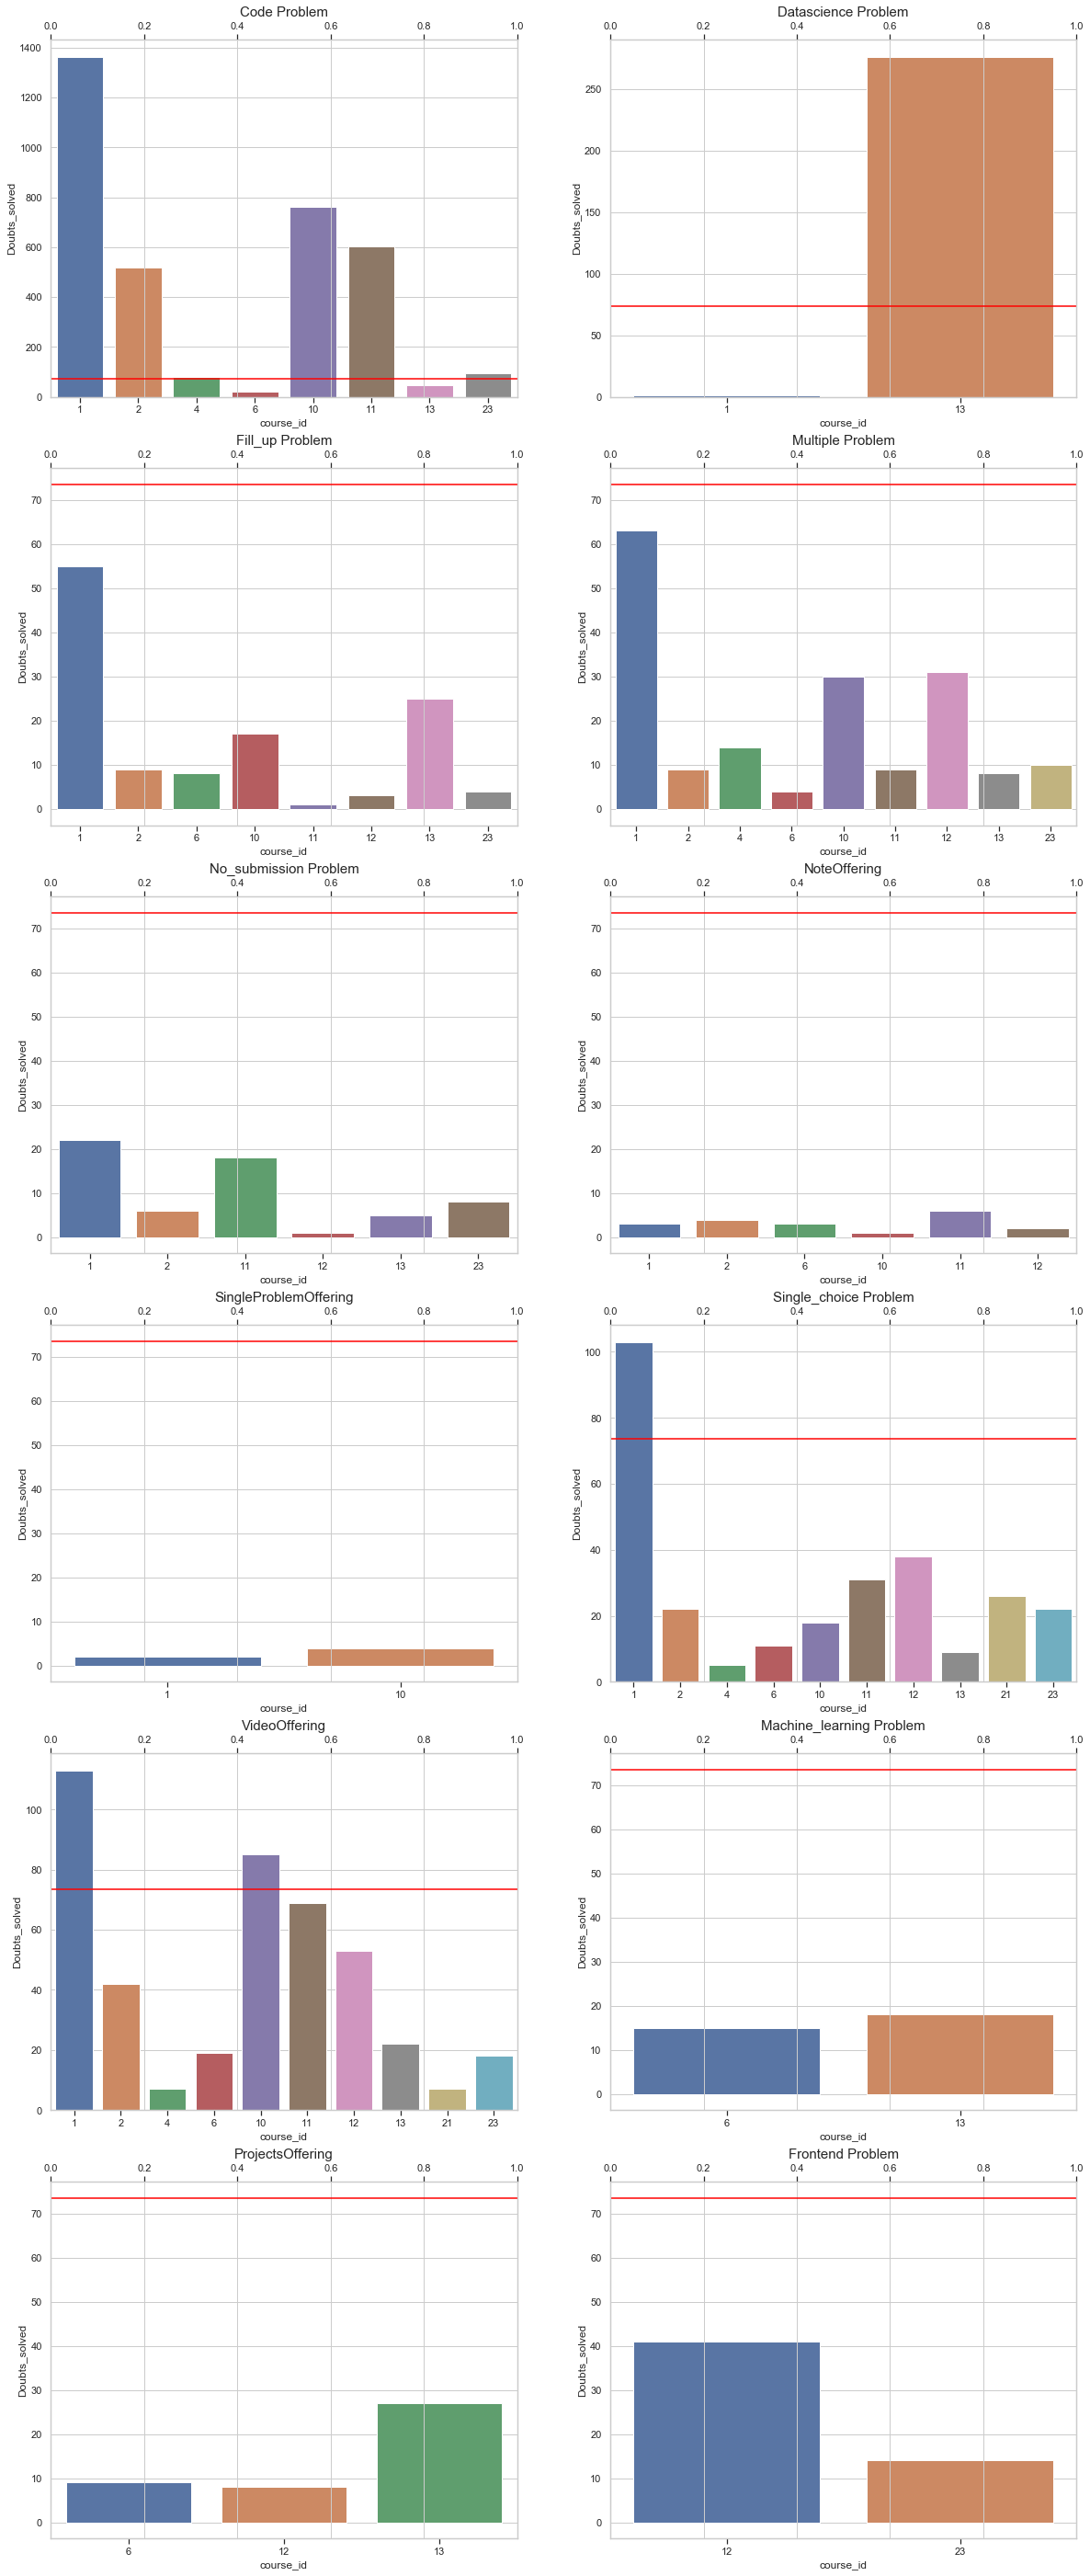

In [16]:
fig, ax = plt.subplots(nrows=int(len(content_types)/2),ncols=2,figsize=(20, 50))
ax=ax.flatten()
req_avg = pt['Doubts_solved'].mean()

for i,ctype in enumerate(content_types):
    t = pt.loc[pt.content_type==ctype]

    g = sns.barplot(x='course_id',y='Doubts_solved', data=t, ax=ax[i], capsize=.2)
    
    #for index, row in t.iterrows():
    #    g.text(row.course_id, row.DLC, row.Doubts_solved, color='black', ha="center")
    
    ax[i].set_title(ctype, fontsize=15)
    
    ax2 = ax[i].twiny()
    ax2 = plt.axhline(y=req_avg,color='red')

**Note**: Observe that the scales of the y-axis in the plot above are different

### The table above and the subplots above denote the same information with tabular and plot form. Let's breakdown the results and information we get.
- <font size="3">```Code Problem```- Courses 1,11 and 13 were there in the system more than the average doubt life cycle and more number of problems are solved and raised which leads us the decision that more TAs should be assigned (or hired) towards increased demand towards code problem solving. Similar issue can be seen with the requests made to this content type
- <font size="3">```Fill up problem``` - Courses 1,6,11,23 have more than average solve times.
- <font size="3">```Multiple problem``` - Courses 1,6,23 have more than average solve times.
- <font size="3">```Single Choice problem``` - Courses 1,11 have more than average solve times.

#### **Takeaways:**
- <font size="3"> Courses 1,11,23 and 6 are pretty popular once, gathering almost all doubt requests and hogging the doubt cycle times.
- <font size="3"> Manepower although already heavy may require stacking up because of popularity

---

# Realtionship between Doubt Life Cycle and User Ratings

### Too see a relationship or interdependency of Doubt Life Cycle(continuous) and User Rating(categorical) we need to see multiple tests and quantify the result if possible. Methods to try:
- <font size="3">`Point biserial Correlation` - Similar to Pearsons correlation but work dichotomous (binarized) variables and assumes normal distribution and linear behaviour.
- <font size="3">`Logistic Regression Coefficients` - It lay out the relationship by transforming the hyperpace using logit function and fits a straight line.
- <font size="3">`ANOVA test` - It works by analyzing how much variance in the continuous data is explained by the variance in categorical one.

In [100]:
DRT_UR = doubts[['Doubt_life_cycle(min)','user_rating']]
DRT_UR = DRT_UR.loc[DRT_UR.user_rating!='NR']
DRT_UR.user_rating = DRT_UR.user_rating.astype(int)
display(DRT_UR)

,Doubt_life_cycle(min),user_rating
0,44.850000,5
1,23.216667,5
2,29.316667,5
3,40.133333,4
4,33.233333,5
...,...,...
4995,52.333333,4
4996,0.000000,5
4997,42.633333,5
4998,57.450000,5


Write about point biserial and kruskal not working

In [26]:
from scipy import stats

In [27]:
stats.pointbiserialr(DRT_UR.user_rating.values, DRT_UR['Doubt_life_cycle(min)'])

PointbiserialrResult(correlation=0.0377768014070839, pvalue=0.0076236253931961885)

<font size="3">```Point Biserial``` reports **0.03** correlation with **p-value of 0.0076** (<0.05) which signifies there isnt enough evidence to rule out null Hypothesis of DLC and User rating of having a relation.
<font size="3"> So, relationship does exist but its close to 0 (according to this method

In [29]:
from sklearn.linear_model import LogisticRegression

In [39]:
lr = LogisticRegression(C=1.0, 
                        class_weight='balanced', #n_samples / (n_classes * np.bincount(y)) 
                        dual=False, 
                        fit_intercept=True,
                        intercept_scaling=1, 
                        l1_ratio=None, 
                        max_iter=100,
                        multi_class='multinomial', 
                        n_jobs=-1, 
                        penalty='l2',
                        random_state=RANDOM_SEED, 
                        solver='newton-cg', 
                        tol=0.0001, 
                        verbose=0,
                        warm_start=False)

In [42]:
X = DRT_UR['Doubt_life_cycle(min)'].values.reshape(-1,1)
y = DRT_UR.user_rating.values

In [43]:
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [45]:
print(lr.coef_)
print(lr.intercept_)

[[-0.00794608]
 [ 0.0062662 ]
 [ 0.00224408]
 [-0.00179991]
 [ 0.0012357 ]]
[ 0.31805654 -0.26011984 -0.08877791  0.07756717 -0.04672595]


<font size="3">According to the Logit method we can see some slopes being negative. We can interpret that **increasing Doubt Times negatively impact the user ratings**. But the quantities are way to less to point to something conclusive.

Text(0.5, 1.0, 'Box Plot to analyze the DLC for every User Rating')

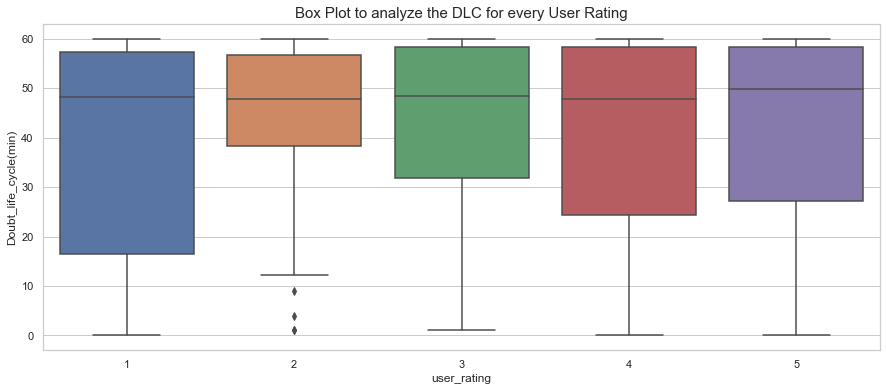

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="user_rating", y="Doubt_life_cycle(min)", data=DRT_UR,ax=ax)

ax.set_title('Box Plot to analyze the DLC for every User Rating', fontsize=15)

#### This can be the possible reason why we aren't able to quanitify our relationship setting.
- <font size="3">User Rating are spread acroess different Doubts times, indirectly hampering the predicting quantification of relationship between the two.
- <font size="3">We can interpret that User rating is not completely dependent on Doubt times (atleast not in this dataset)

# Activities table analysis

In [102]:
activities

,id,user_id,doubt_id,created_at,activity_type,is_student_id,is_TA_id,is_sys_id
0,2121357,120623,248193,2020-01-01 04:26:08+00:00,assign,0,1,0
1,2121358,120623,248193,2020-01-01 04:26:15+00:00,accept,0,1,0
2,2121359,165368,248199,2020-01-01 04:29:18+00:00,assign,0,1,0
3,2121360,165368,248199,2020-01-01 04:29:34+00:00,reject,0,1,0
4,2121399,265305,248191,2020-01-01 04:35:07+00:00,assign,0,1,0
...,...,...,...,...,...,...,...,...
76203,4322614,229989,252698,2020-05-01 12:26:00+00:00,rate,1,0,0
76204,4322618,229989,249512,2020-05-01 12:26:07+00:00,rate,1,0,0
76205,4699532,47336,249949,2020-05-12 13:53:29+00:00,rate,1,0,0
76206,4905034,175678,252370,2020-05-18 13:24:14+00:00,rate,1,0,0


Text(0, 0.5, 'Count')

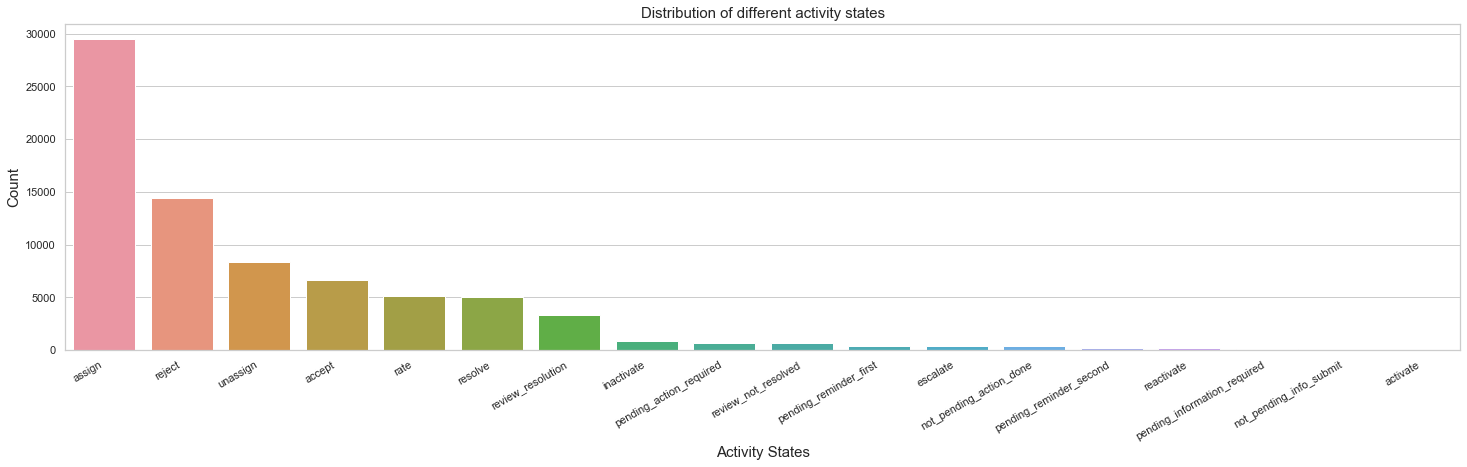

In [62]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x=activities.activity_type.value_counts().index,y=activities.activity_type.value_counts(),ax=ax,capsize=.2)

ax.set_title('Distribution of different activity states', fontsize=15)
ax.set_xlabel('Activity States',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_ylabel('Count',fontsize=15)

- <font size="3">Lots of doubts have assign state but not make their way through the whole pipeline which is possible since they are intermediate states.
- <font size="3">Reject count is quite high, which is not a good thing.

### Which of the doubts were assigned but never completed or resolved (in this database) and which course id and content type do they belong to

In [73]:
d_id1 = activities.doubt_id.unique()
d_id2 = doubts.id.unique()

In [74]:
np.setdiff1d(d_id1,d_id2,assume_unique=True)

array([], dtype=int64)

<font size="3"> Since ever doubt every entered the database is resolved which is a feat in itself, its quite surprising how the doubt isn't gone through the pipline shown in above bar plot. Most probable reason can be data storing or removal of non-essential intermediate states.

---

---